In [1]:
import cv2

Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.9081
Loop 1 Serial execution time: 8137ms

Serial Average execution time: 8137ms. 
New record has been appended to time_result.json

Omp PSNR embedding : 45.4096
Loop 1 OMP execution time: 6878ms

OMP Average execution time: 6878ms. 
New record has been appended to time_result.json

CUDA PSNR embedding : 45.433
Loop 1 CUDA execution time: 1442ms

CUDA Average execution time: 1442ms. 
New record has been appended to time_result.json



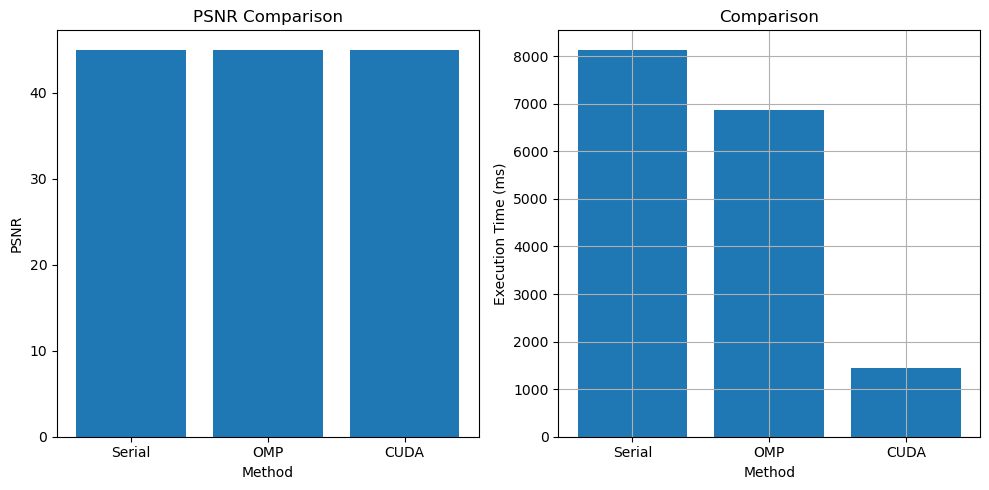

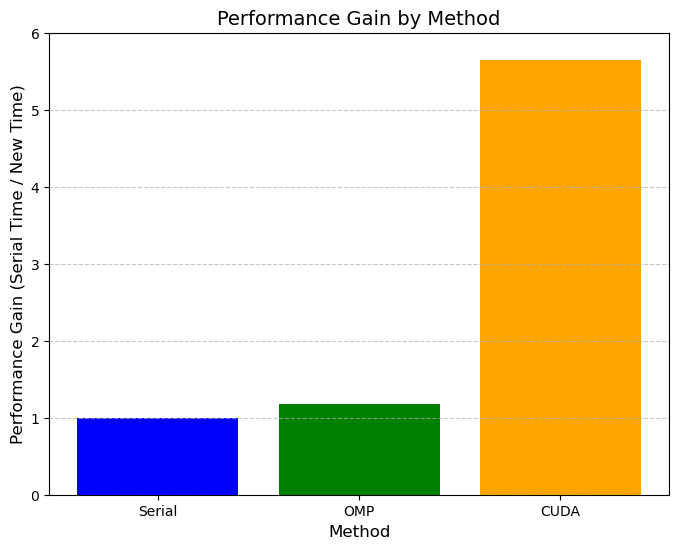

Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.9081
Loop 1 Serial execution time: 8221ms

Serial Average execution time: 8221ms. 
New record has been appended to time_result.json



In [ ]:
import subprocess
import matplotlib.pyplot as plt
import json
import numpy as np
from PIL import Image

def get_image_total_pixels(image_path):
  try:
    img = Image.open(image_path)
    width, height = img.size
    total_pixels = width * height
    return total_pixels
  except FileNotFoundError:
    print(f"Image not found at: {image_path}")
    return None
  except Exception as e:
    print(f"Error loading image: {e}")
    return None
    
def run_cpp_executable(executable_path, args):
 
  try:
    result = subprocess.run([executable_path] + args, 
                           stdout=subprocess.PIPE, 
                           stderr=subprocess.PIPE, 
                           check=True,
                           text=True)
    return result.stdout
  except subprocess.CalledProcessError as e:
    print(f"Error executing {executable_path}: {e}")
    return ""
#
original_images = ["home.jpg", "home.jpg","home.jpg"]
loop_number = "1"
executable_path = "./x64/Release/DWTSVD_Watermarking.exe"  
#<original_image_path> <watermark_image_path> <watermark_width> <watermark_height> <type> <loop_number>
#For type: 0 = Serial, 1 = OMP, 2 = CUDA, 3 = MPI

def plot_comparison(data):
    # Define the desired order of methods
    ordered_methods = ['seq', 'omp', 'mpi','cuda'] 
    # Extract data in the desired order
    methods = [method for method in ordered_methods if method in data] 
    embed_times = [data[method]['embed_time'] for method in methods]
    extract_times = [data[method]['extract_time'] for method in methods]
    psnrs = [data[method]['psnr'] for method in methods]

    x = np.arange(len(methods))

    methods = [d["method"] for d in data]
    psnrs = [d["psnr"] for d in data]
    times = [d["time"] for d in data]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot PSNR comparison
    axs[0].bar(methods, psnrs)
    axs[0].set_xlabel("Method")
    axs[0].set_ylabel("PSNR")
    axs[0].set_title("PSNR Comparison")

    # Plot execution time comparison
    axs[1].bar(methods, times)
    axs[1].set_xlabel("Method")
    axs[1].set_ylabel("Execution Time (ms)")
    axs[1].set_title("Execution Time Comparison")

    plt.title('Comparison')
    fig.tight_layout()
    plt.grid(True)
    plt.show()
    
    methods = [item["method"] for item in data]
    times = [item["time"] for item in data]
    
    # Serial time
    serial_time = next(item["time"] for item in data if item["method"] == "Serial")
    
    # Calculate performance gain
    performance_gains = [serial_time / time for time in times]
    
    # Create bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(methods, performance_gains, color=['blue', 'green', 'orange'])
    plt.title("Performance Gain by Method", fontsize=14)
    y_ticks = np.arange(0, int(max(performance_gains)) + 2, 1) 
    plt.yticks(y_ticks)
    plt.xlabel("Method", fontsize=12)
    plt.ylabel("Performance Gain (Serial Time / New Time)", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

image_paths = [
    "./resized_home.jpg", 
    "./serial_watermarked_image.tiff", 
    "./omp_watermarked_image.tiff", 
    "./cuda_watermarked_image.tiff",
    "./mpi_watermarked_image.tiff"
]

# Load data from JSON file


for i in original_images:
    open('time_result.json', 'w').close()
    args = [i, "mono.png", "64", "64", "0", loop_number] 
    
    output = run_cpp_executable(executable_path, args)
    print(output) 
    args = [i, "mono.png", "64", "64", "1", loop_number] 
    
    output = run_cpp_executable(executable_path, args)
    print(output) 
    args = [i, "mono.png", "64", "64", "2", loop_number] 
    
    output = run_cpp_executable(executable_path, args)
    print(output) 
    with open('time_result.json', 'r') as f:
        data = json.load(f)

    plot_comparison(data) 


Total pixels in the image: 431280


Total pixels in the image: 431280


In [ ]:

import matplotlib.pyplot as plt
import json
import numpy as np

def plot_comparison(data):
    # Define the desired order of methods
    ordered_methods = ['seq', 'omp', 'mpi','cuda'] 
    # Extract data in the desired order
    methods = [method for method in ordered_methods if method in data] 
    embed_times = [data[method]['embed_time'] for method in methods]
    extract_times = [data[method]['extract_time'] for method in methods]
    psnrs = [data[method]['psnr'] for method in methods]

    x = np.arange(len(methods))

    methods = [d["method"] for d in data]
    psnrs = [d["psnr"] for d in data]
    times = [d["time"] for d in data]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot PSNR comparison
    axs[0].bar(methods, psnrs)
    axs[0].set_xlabel("Method")
    axs[0].set_ylabel("PSNR")
    axs[0].set_title("PSNR Comparison")

    # Plot execution time comparison
    axs[1].bar(methods, times)
    axs[1].set_xlabel("Method")
    axs[1].set_ylabel("Execution Time (ms)")
    axs[1].set_title("Execution Time Comparison")

    plt.title('Comparison')
    fig.tight_layout()
    plt.grid(True)
    plt.show()
    
    methods = [item["method"] for item in data]
    times = [item["time"] for item in data]
    
    # Serial time
    serial_time = next(item["time"] for item in data if item["method"] == "Serial")
    
    # Calculate performance gain
    performance_gains = [serial_time / time for time in times]
    
    # Create bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(methods, performance_gains, color=['blue', 'green', 'orange'])
    plt.title("Performance Gain by Method", fontsize=14)
    y_ticks = np.arange(0, int(max(performance_gains)) + 2, 1) 
    plt.yticks(y_ticks)
    plt.xlabel("Method", fontsize=12)
    plt.ylabel("Performance Gain (Serial Time / New Time)", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

image_paths = [
    "./resized_home.jpg", 
    "./serial_watermarked_image.tiff", 
    "./omp_watermarked_image.tiff", 
    "./cuda_watermarked_image.tiff",
    "./mpi_watermarked_image.tiff"
]

# Load data from JSON file
with open('time_result.json', 'r') as f:
    data = json.load(f)

# Plot the comparison
plot_comparison(data) 

Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.9081
Loop 1 Serial execution time: 9011ms

Serial Average execution time: 9011ms. 
New record has been appended to time_result.json

Omp PSNR embedding : 45.4096
Loop 1 OMP execution time: 7144ms

OMP Average execution time: 7144ms. 
New record has been appended to time_result.json

CUDA PSNR embedding : 45.433
Loop 1 CUDA execution time: 1462ms

CUDA Average execution time: 1462ms. 
New record has been appended to time_result.json



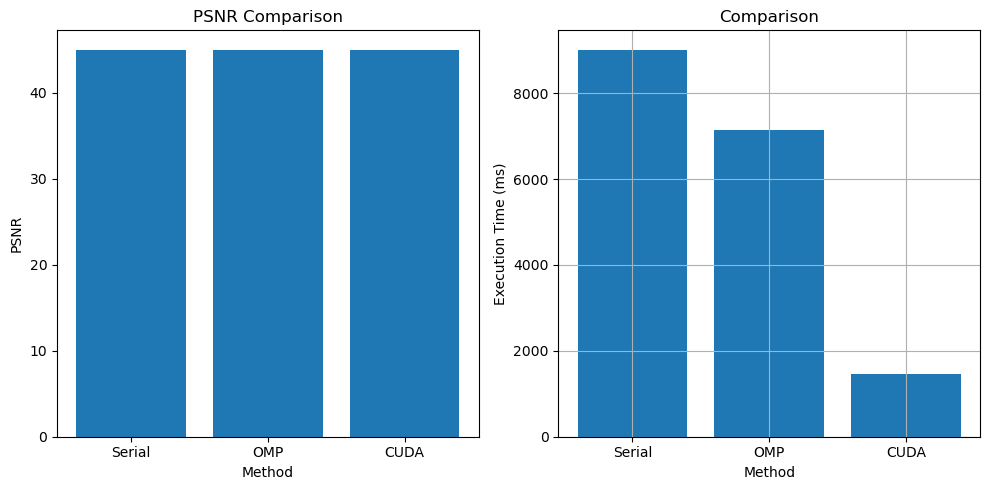

Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 45.3058
Loop 1 Serial execution time: 187795ms

Serial Average execution time: 187795ms. 
New record has been appended to time_result.json

Omp PSNR embedding : 45.3058
Loop 1 OMP execution time: 156890ms

OMP Average execution time: 156890ms. 
New record has been appended to time_result.json

CUDA PSNR embedding : 45.3055
Loop 1 CUDA execution time: 4168ms

CUDA Average execution time: 4168ms. 
New record has been appended to time_result.json



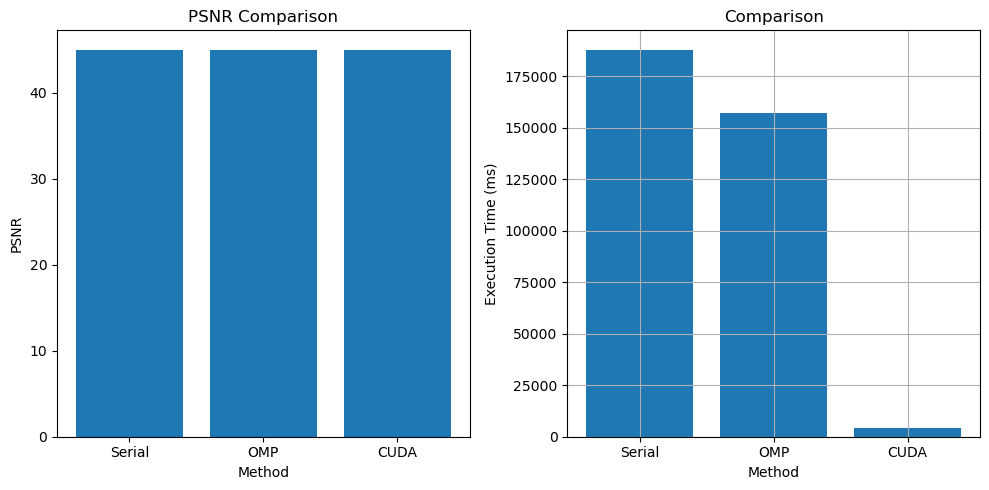

Original resized image saved as 'serial_watermarked_image.tiff'.
Sequential PSNR embedding : 43.571
Loop 1 Serial execution time: 184166ms

Serial Average execution time: 184166ms. 
New record has been appended to time_result.json

Omp PSNR embedding : 43.5712
Loop 1 OMP execution time: 149687ms

OMP Average execution time: 149687ms. 
New record has been appended to time_result.json

CUDA PSNR embedding : 43.5704
Loop 1 CUDA execution time: 4052ms

CUDA Average execution time: 4052ms. 
New record has been appended to time_result.json



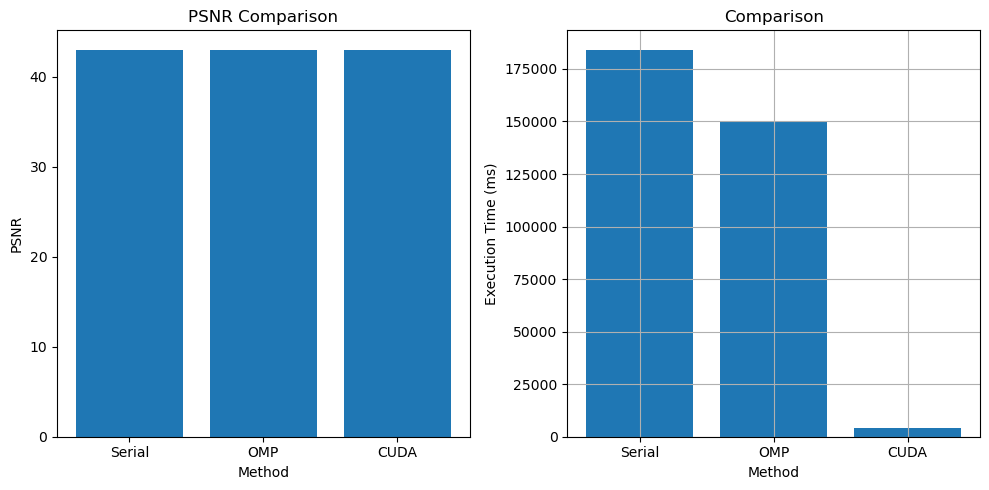